<a href="https://colab.research.google.com/github/aavila4/BME450-EKGanalysis/blob/main/BME450_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path to dataset files: /kaggle/input/ecg-image-data
Files/Folders in dataset path: ['ECG_Image_data']
Using device: cpu
Classes: ['F', 'M', 'N', 'Q', 'S', 'V']
Train subset size: 9919, Test subset size: 2479
Epoch [1/5] Train Loss: 0.0898 Test Loss: 0.0052 Test Accuracy: 99.92%
Epoch [2/5] Train Loss: 0.0001 Test Loss: 0.0045 Test Accuracy: 99.92%
Epoch [3/5] Train Loss: 0.0000 Test Loss: 0.0052 Test Accuracy: 99.92%
Epoch [4/5] Train Loss: 0.0000 Test Loss: 0.0036 Test Accuracy: 99.92%
Epoch [5/5] Train Loss: 0.0000 Test Loss: 0.0047 Test Accuracy: 99.92%


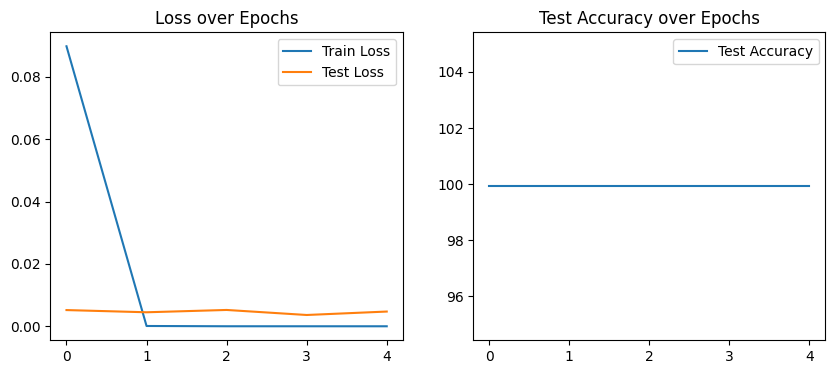

Model saved to ecg_cnn_model.pth


In [ ]:
#Pre-optimized 3-Convolution Block Model
import kagglehub
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Load Dataset via kagglehub
path = kagglehub.dataset_download("erhmrai/ecg-image-data")
print("Path to dataset files:", path)

print("Dataset Path:", path)
print("Files/Folders in dataset path:")
print(os.listdir(path))

data_root = os.path.join(path, "ECG_Image_data")
train_dir = os.path.join(data_root, "train")
test_dir = os.path.join(data_root, "test")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
BATCH_SIZE = 16
IMG_SIZE = (128, 128)
EPOCHS = 20
LEARNING_RATE = 0.001

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Classes:", train_dataset.classes)
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")


# Show Sample Images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images[:8]))
print("Labels:", labels.numpy())

# CNN Model Definition
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize Model, Loss, Optimizer
num_classes = len(train_dataset.classes)
model = ImprovedCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training Loop
train_losses, test_losses, test_accuracies = [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluate
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} "
          f"Test Loss: {test_losses[-1]:.4f} "
          f"Test Accuracy: {test_accuracy:.2f}%")

# Plot Loss and Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Test Accuracy over Epochs")
plt.legend()
plt.show()


# Save the Trained Model
torch.save(model.state_dict(), "ecg_cnn_model.pth")
print("Model saved to ecg_cnn_model.pth")


Epoch [1/10] Train Loss: 0.9736 Test Loss: 0.6454 Test Accuracy: 81.78%
Epoch [2/10] Train Loss: 0.5446 Test Loss: 0.2736 Test Accuracy: 97.17%
Epoch [3/10] Train Loss: 0.2225 Test Loss: 0.0814 Test Accuracy: 97.17%
Epoch [4/10] Train Loss: 0.0780 Test Loss: 0.0270 Test Accuracy: 100.00%
Epoch [5/10] Train Loss: 0.0284 Test Loss: 0.0130 Test Accuracy: 99.60%
Epoch [6/10] Train Loss: 0.0135 Test Loss: 0.0085 Test Accuracy: 100.00%
Epoch [7/10] Train Loss: 0.0097 Test Loss: 0.0076 Test Accuracy: 100.00%
Epoch [8/10] Train Loss: 0.0069 Test Loss: 0.0065 Test Accuracy: 100.00%
Epoch [9/10] Train Loss: 0.0052 Test Loss: 0.0058 Test Accuracy: 100.00%
Epoch [10/10] Train Loss: 0.0043 Test Loss: 0.0049 Test Accuracy: 100.00%


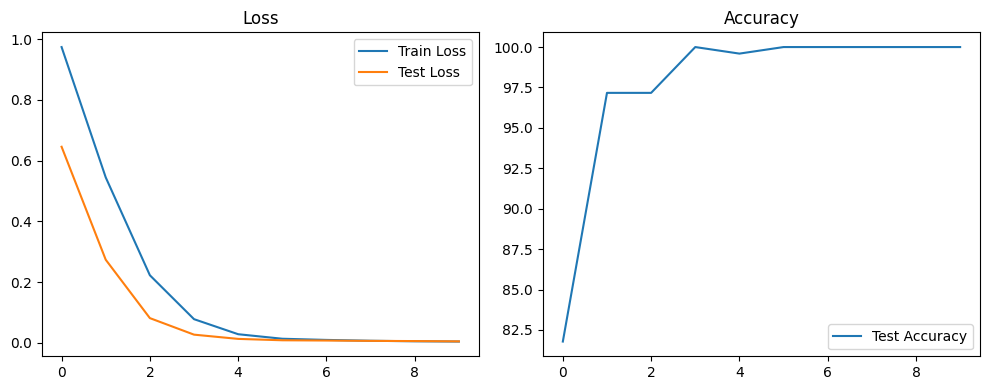

In [ ]:
#Model with 2-Convolutional Blocks

import kagglehub
import os, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = kagglehub.dataset_download("erhmrai/ecg-image-data")
train_dir = os.path.join(path, "ECG_Image_data", "train")
test_dir = os.path.join(path, "ECG_Image_data", "test")

# Config
IMG_SIZE = (64, 64)
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001
SUBSET_FRACTION = 0.01

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def get_subset(dataset, fraction):
    size = int(len(dataset) * fraction)
    indices = random.sample(range(len(dataset)), size)
    return Subset(dataset, indices)

train_dataset = get_subset(datasets.ImageFolder(train_dir, transform), SUBSET_FRACTION)
test_dataset = get_subset(datasets.ImageFolder(test_dir, transform), SUBSET_FRACTION)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Model: 2 Convolution Layer CNN
num_classes = len(train_loader.dataset.dataset.classes)
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                       # -> 32 x 32 x 32
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                       # -> 64 x 16 x 16
    nn.Flatten(),
    nn.Linear(64 * 16 * 16, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training Loop
train_losses, test_losses, test_accuracies = [], [], []
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    correct, total, test_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    test_accuracy = 100 * correct / total
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} "
          f"Test Loss: {test_losses[-1]:.4f} "
          f"Test Accuracy: {test_accuracy:.2f}%")

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

torch.save(model.state_dict(), "two_conv_cnn.pth")

Epoch [1/10] Train Loss: 2.3925 Test Loss: 1.2119 Test Accuracy: 83.00%
Epoch [2/10] Train Loss: 0.6422 Test Loss: 0.4347 Test Accuracy: 87.45%
Epoch [3/10] Train Loss: 0.2502 Test Loss: 0.1989 Test Accuracy: 93.52%
Epoch [4/10] Train Loss: 0.1147 Test Loss: 0.1108 Test Accuracy: 95.95%
Epoch [5/10] Train Loss: 0.0563 Test Loss: 0.0787 Test Accuracy: 97.57%
Epoch [6/10] Train Loss: 0.0343 Test Loss: 0.0535 Test Accuracy: 99.19%
Epoch [7/10] Train Loss: 0.0233 Test Loss: 0.0502 Test Accuracy: 98.38%
Epoch [8/10] Train Loss: 0.0181 Test Loss: 0.0459 Test Accuracy: 98.79%
Epoch [9/10] Train Loss: 0.0149 Test Loss: 0.0444 Test Accuracy: 98.79%
Epoch [10/10] Train Loss: 0.0121 Test Loss: 0.0406 Test Accuracy: 98.79%


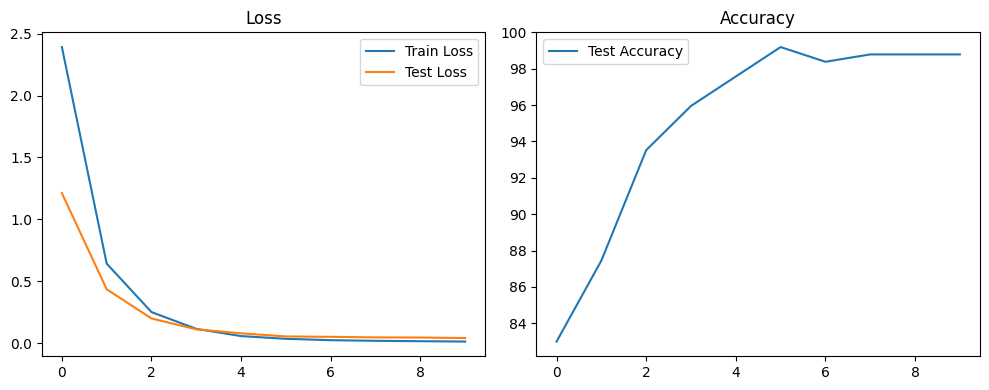

In [ ]:
#Model with 1-Convolutional Block

import kagglehub
import os, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = kagglehub.dataset_download("erhmrai/ecg-image-data")
train_dir = os.path.join(path, "ECG_Image_data", "train")
test_dir = os.path.join(path, "ECG_Image_data", "test")

# Config
IMG_SIZE = (64, 64)
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001
SUBSET_FRACTION = 0.01

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def get_subset(dataset, fraction):
    size = int(len(dataset) * fraction)
    indices = random.sample(range(len(dataset)), size)
    return Subset(dataset, indices)

train_dataset = get_subset(datasets.ImageFolder(train_dir, transform), SUBSET_FRACTION)
test_dataset = get_subset(datasets.ImageFolder(test_dir, transform), SUBSET_FRACTION)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Model: 1 Convolution Layer CNN
num_classes = len(train_loader.dataset.dataset.classes)
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                        # Output: 32 x 32 x 32
    nn.Flatten(),
    nn.Linear(32 * 32 * 32, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training Loop
train_losses, test_losses, test_accuracies = [], [], []
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    correct, total, test_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    test_accuracy = 100 * correct / total
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} "
          f"Test Loss: {test_losses[-1]:.4f} "
          f"Test Accuracy: {test_accuracy:.2f}%")

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

torch.save(model.state_dict(), "one_conv_cnn.pth")

Epoch [1/10] Train Loss: 1.0009 Test Loss: 0.8724 Test Accuracy: 75.71%
Epoch [2/10] Train Loss: 0.7887 Test Loss: 0.8521 Test Accuracy: 75.71%
Epoch [3/10] Train Loss: 0.6953 Test Loss: 0.5869 Test Accuracy: 81.38%
Epoch [4/10] Train Loss: 0.4335 Test Loss: 0.3332 Test Accuracy: 84.62%
Epoch [5/10] Train Loss: 0.2247 Test Loss: 0.1894 Test Accuracy: 95.95%
Epoch [6/10] Train Loss: 0.1295 Test Loss: 0.1378 Test Accuracy: 95.95%
Epoch [7/10] Train Loss: 0.0971 Test Loss: 0.0952 Test Accuracy: 97.98%
Epoch [8/10] Train Loss: 0.0723 Test Loss: 0.0701 Test Accuracy: 98.38%
Epoch [9/10] Train Loss: 0.0504 Test Loss: 0.0492 Test Accuracy: 99.60%
Epoch [10/10] Train Loss: 0.0394 Test Loss: 0.0507 Test Accuracy: 99.19%


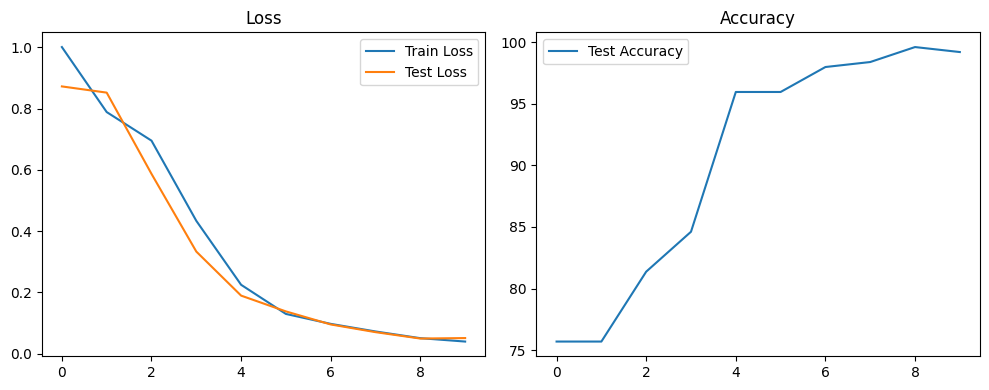

In [ ]:
#Depthwise Separation CNN

import kagglehub
import os, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = kagglehub.dataset_download("erhmrai/ecg-image-data")
train_dir = os.path.join(path, "ECG_Image_data", "train")
test_dir = os.path.join(path, "ECG_Image_data", "test")

# Config
IMG_SIZE = (64, 64)
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001
SUBSET_FRACTION = 0.01

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def get_subset(dataset, fraction):
    size = int(len(dataset) * fraction)
    indices = random.sample(range(len(dataset)), size)
    return Subset(dataset, indices)

train_dataset = get_subset(datasets.ImageFolder(train_dir, transform), SUBSET_FRACTION)
test_dataset = get_subset(datasets.ImageFolder(test_dir, transform), SUBSET_FRACTION)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Depthwise Separable CNN
num_classes = len(train_loader.dataset.dataset.classes)
model = nn.Sequential(
    nn.Conv2d(3, 3, kernel_size=3, padding=1, groups=3),  # depthwise
    nn.Conv2d(3, 32, kernel_size=1),                      # pointwise
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                                   # 32 x 32 x 32
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                                   # 64 x 16 x 16
    nn.Flatten(),
    nn.Linear(64 * 16 * 16, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training Loop
train_losses, test_losses, test_accuracies = [], [], []
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    correct, total, test_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    test_accuracy = 100 * correct / total
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} "
          f"Test Loss: {test_losses[-1]:.4f} "
          f"Test Accuracy: {test_accuracy:.2f}%")

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

torch.save(model.state_dict(), "depthwise_separable_cnn.pth")

In [ ]:
#SqueezeNet Model

